In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm



In [2]:
#Load the data
file_path = r"C:\Users\daves\OneDrive\Pessoal\Acadêmico\Mestrado\Dissertação - Execução\Análises\Dados do Censo - não usar na regressão\PIA individuais.xlsx"
df = pd.read_excel(file_path, sheet_name="Cuiabá")

# Filter out zeros or negative values before log transformation
df = df[df['Totalammount'] > 0].copy()
df['log_Totalammount'] = np.log(df['Totalammount'])

# List of municipalities
municipalities = [
    "Acorizal", "Barão de Melgaço", "Campo Verde", "Chapada dos Guimarães",
    "Cuiabá", "Jangada", "Nobres", "Nossa Senhora do Livramento",
    "Nova Brasilândia", "Planalto da Serra", "Poconé", "Rosário Oeste",
    "Santo Antônio do Leverger", "Várzea Grande"
]

# Colors and line styles
colors = [
    'green', 'green', 'blue', 'blue',
    'red', 'black', 'black', 'yellow',
    'yellow', 'orange', 'purple', 'gray',
    'gray', 'brown'
]

line_styles = [
    '--', '-', '--', '-',
    '--', '-', '--', '-',
    '--', '-', '--', '-',
    '--', '-'
]


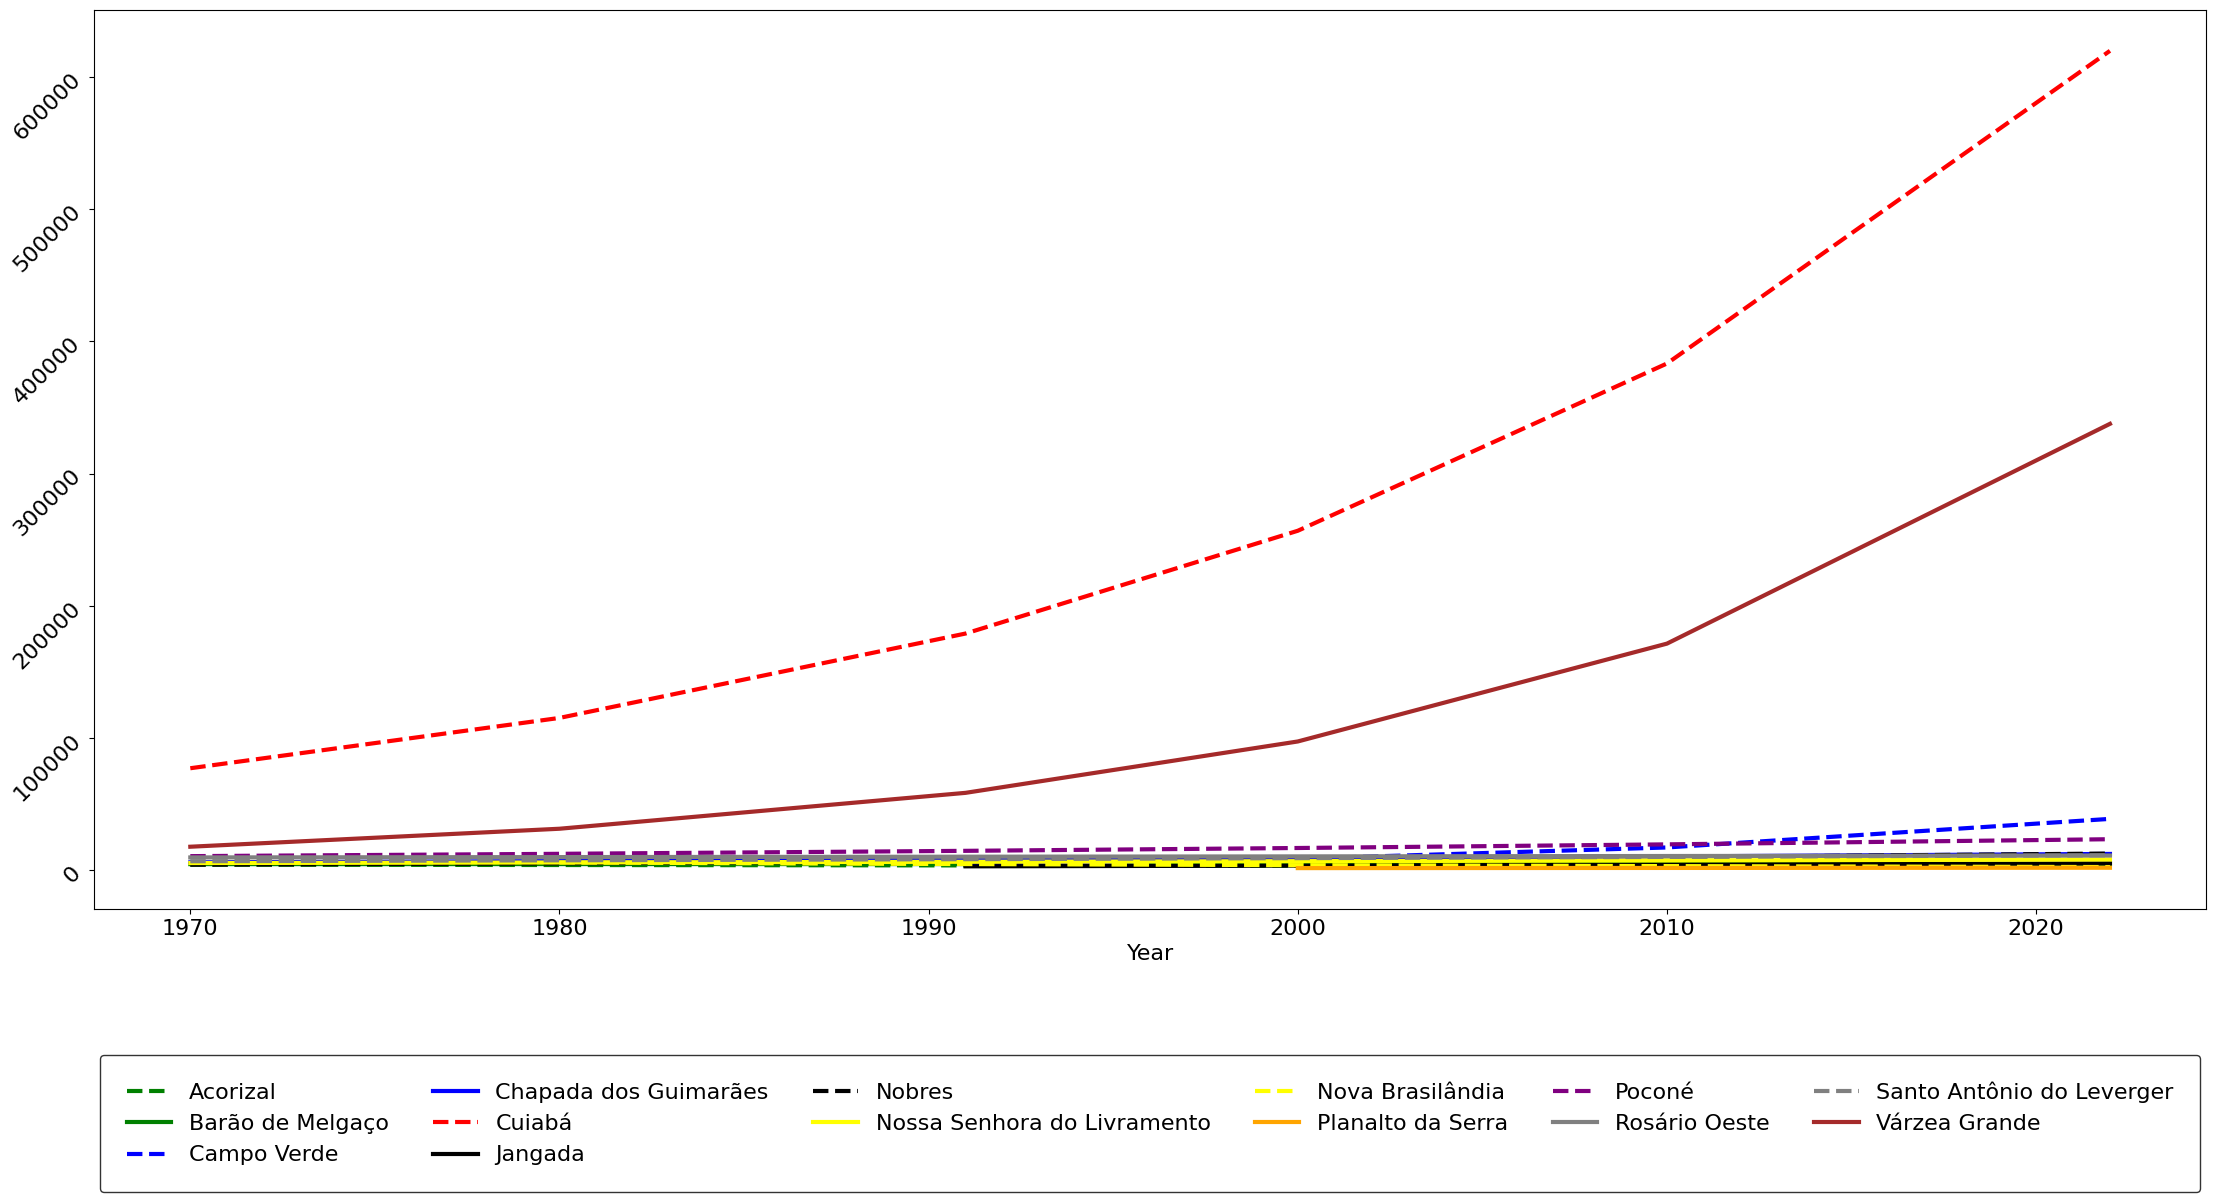

In [3]:
# Create figure with larger size to accommodate bigger fonts
plt.figure(figsize=(24, 16))

# Set global font size to 16
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 16,
    'axes.labelsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16
})

# For each municipality, perform exponential fit and plot
for i, mun in enumerate(municipalities):
    mun_df = df[df['Municipios'] == mun]
    if len(mun_df) >= 2:  # Need at least 2 points for a fit
        try:
            # Fit log-linear model (equivalent to exponential)
            X = sm.add_constant(mun_df['Year'])
            y = mun_df['log_Totalammount']
            model = sm.OLS(y, X).fit()
            
            # Generate predictions
            years = np.array(sorted(mun_df['Year'].unique()))
            X_pred = sm.add_constant(years)
            log_pred = model.predict(X_pred)
            pred = np.exp(log_pred)
            
            # Plot the fitted line with thicker lines
            plt.plot(years, pred, 
                     color=colors[i], 
                     linestyle=line_styles[i], 
                     linewidth=3.0,
                     label=mun)
        except:
            print(f"Could not fit exponential curve for {mun} - possibly insufficient data")
            continue

# Customize the plot - REMOVED Y-AXIS LABEL
plt.xlabel('Year', fontsize=16)
plt.ylabel('')  # Empty string removes y-axis label
plt.yticks(rotation=45)
plt.grid(False)

# Legend settings with larger font
legend = plt.legend(
    fontsize=16,
    ncol=6,
    bbox_to_anchor=(0.5, -0.15),
    loc='upper center',
    frameon=True,
    framealpha=0.8,
    edgecolor='black',
    borderpad=1.2
)

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0.15, 1, 0.95])

# Save the plot with 1200 DPI
output_path = r"C:/Users/daves/OneDrive/Pessoal/Acadêmico/Mestrado/Dissertação - Execução/Dissertação/Quadros e gráficos/Graph8.jpg"
plt.savefig(output_path, dpi=1200, bbox_inches='tight', facecolor='white')

plt.show()

In [6]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import plotly.graph_objects as go

def logistic_function(x, capacity, growth_rate, x0):
    """The logistic function."""
    return capacity / (1 + np.exp(-growth_rate * (x - x0)))

def create_interactive_logistic_fit_municipalities(file_path, sheet_name, municipalities, output_path=None, show_plot=False):
    """
    Creates and saves an interactive plot with logistic fits
    for total amount by municipality within a specified list. A dropdown menu
    allows selection of individual municipalities. Only logistic fitted lines are shown,
    and all municipalities are displayed by default.
    """
    # Read data
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return
    except KeyError:
        print(f"Error: Sheet '{sheet_name}' not found in the Excel file.")
        return

    # Filter data for the specified municipalities
    df_filtered = df[df['Municipios'].isin(municipalities)].copy()
    if df_filtered.empty:
        print(f"No data found for the specified municipalities in sheet '{sheet_name}'.")
        return

    # Define a default color palette for municipalities
    default_colors = [
        'blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray',
        'olive', 'cyan', 'magenta', 'yellow', 'teal', 'lime'
    ]
    municipality_colors = {mun: default_colors[i % len(default_colors)] for i, mun in enumerate(municipalities)}

    line_width = 2.5
    available_municipalities = df_filtered['Municipios'].unique()
    fig = go.Figure()

    for municipality in available_municipalities:
        if municipality not in municipality_colors:
            continue

        mun_df = df_filtered[df_filtered['Municipios'] == municipality]
        years = np.array(mun_df['Year'])
        amounts = np.array(mun_df['Totalammount'])

        if len(mun_df) < 3:  # Need at least 3 points for a logistic fit
            print(f"Insufficient data for logistic fit for {municipality}")
            continue

        color = municipality_colors[municipality]
        years_pred = np.linspace(min(years) - 2, max(years) + 2, 100)

        # Try logistic fit
        try:
            p0 = [max(amounts) * 1.5, 0.5, np.median(years)]
            bounds = ([max(amounts), 0.01, min(years)], [max(amounts) * 10, 5, max(years)])
            popt_logistic, _ = curve_fit(logistic_function, years, amounts, p0=p0, bounds=bounds, maxfev=10000)
            pred_logistic = logistic_function(years_pred, *popt_logistic)

            fig.add_trace(go.Scatter(x=years_pred, y=pred_logistic, mode='lines',
                                 line=dict(color=color, width=line_width),
                                 name=municipality,
                                 visible=True,  # Set all traces to visible by default
                                 hovertemplate='Year: %{x}<br>Total Amount: %{y:.2f}<extra></extra>'))
        except RuntimeError:
            print(f"Could not fit logistic curve for {municipality}")
        except Exception as e:
            print(f"An error occurred during logistic fit for {municipality}: {e}")

    # Create dropdown buttons to toggle visibility
    buttons = []
    buttons.append(dict(label="All",
                        method="update",
                        args=[{"visible": [True] * len(fig.data)},
                              {"title": "Total Amount Logistic Fits for All Municipalities"}]))
    for i, municipality in enumerate(available_municipalities):
        visible = [False] * len(fig.data)
        for j, trace in enumerate(fig.data):
            if trace.name == municipality:
                visible[j] = True
        buttons.append(dict(label=municipality,
                            method="update",
                            args=[{"visible": visible},
                                  {"title": f"Total Amount Logistic Fit for {municipality}"}]))

    # Update layout with dropdown
    fig.update_layout(
        updatemenus=[
            dict(
                buttons=buttons,
                direction="down",
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.1,
                xanchor="left",
                y=1.15,
                yanchor="top",
            )
        ],
        title='Total Amount Logistic Fits for All Municipalities',
        xaxis_title='Year',
        yaxis_title='Total Amount',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.2,
            xanchor="center",
            x=0.5,
            font=dict(size=12),
            traceorder="normal"
        ),
        font=dict(size=14),
        plot_bgcolor='white',
        xaxis=dict(showgrid=True, gridcolor='lightgray'),
        yaxis=dict(showgrid=True, gridcolor='lightgray')
    )

    # Save the plot to an HTML file
    if output_path:
        fig.write_html(output_path)
        print(f"Interactive plot saved to: {output_path}")

    if show_plot:
        fig.show()

    return fig

# Define file path and sheet name
file_path = r"C:\Users\daves\OneDrive\Pessoal\Acadêmico\Mestrado\Dissertação - Execução\Análises\Dados do Censo - não usar na regressão\PIA individuais.xlsx"
sheet_name = "Cuiabá"

# List of municipalities (Cuiabá Immediate Region)
municipalities = [
    "Acorizal", "Barão de Melgaço", "Campo Verde", "Chapada dos Guimarães",
    "Cuiabá", "Jangada", "Nobres", "Nossa Senhora do Livramento",
    "Nova Brasilândia", "Planalto da Serra", "Poconé", "Rosário Oeste",
    "Santo Antônio do Leverger", "Várzea Grande"
]

# Output path for the HTML file
output_path = r"C:/Users/daves/OneDrive/Pessoal/Acadêmico/Mestrado/Dissertação - Execução/Dissertação/Quadros e gráficos/WAP(Cuiabá Immediate Region).html"

# Run the function
create_interactive_logistic_fit_municipalities(
    file_path=file_path,
    sheet_name=sheet_name,
    municipalities=municipalities,
    output_path=output_path,
    show_plot=True  # Set show_plot to True
)

Interactive plot saved to: C:/Users/daves/OneDrive/Pessoal/Acadêmico/Mestrado/Dissertação - Execução/Dissertação/Quadros e gráficos/WAP(Cuiabá Immediate Region).html
